In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 预处理

In [2]:
data_dir = './{}/'
nb_class = len(os.listdir(data_dir.format('train')))
data = {}
for i in ['train', 'valid']:
    data[i] = {x: os.listdir(data_dir.format(i)+x) for x in os.listdir(data_dir.format(i))}
nb_train_samples = sum([len(data['train'][x]) for x in data['train'].keys()])
nb_valid_samples = sum([len(data['valid'][x]) for x in data['train'].keys()])

## 图像变换

暂时参考以下博文为蓝本：https://zhuanlan.zhihu.com/p/26693647

In [3]:
datagen = {'train': image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
),
           'valid':image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)
          }

用了`preprocess_input()`就不需要`rescale`参数了。

https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras

In [4]:
im_width, im_height = 224, 224
batch_size = 64

generator = {x: datagen[x].flow_from_directory(
    data_dir.format(x),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 0,
    class_mode = 'binary'
) for x in datagen.keys()}

Found 16662 images belonging to 2 classes.
Found 8208 images belonging to 2 classes.


## 载入模型

载入模型并排除顶部的全连接层。

In [5]:
model_base = ResNet50(weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

In [6]:
model_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

添加自己的层：

In [7]:
model = Sequential()
model.add(model_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                51250     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 25,737,189
Trainable params: 25,684,069
Non-trainable params: 53,120
___________________________________________________________

查看冻结层前后的可训练层数：

In [9]:
print('Number of trainable weights befor freezing the model_base:', len(model.trainable_weights))
model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

Number of trainable weights befor freezing the model_base: 218
Number of trainable weights after freezing the model_base: 6


编译模型：

In [10]:
lr = 0.0001
# from keras.utils import multi_gpu_model
# model = multi_gpu_model(model_base, gpus=8)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=lr, momentum=0.9), metrics=["accuracy"])

训练模型：

In [11]:
history = model.fit_generator(generator['train'],
                              steps_per_epoch=nb_train_samples // batch_size,
                              epochs=15,
                              validation_data=generator['valid'],
                              validation_steps=nb_valid_samples // batch_size)

Epoch 1/15
260/260 [==============================] - 392s 2s/step - loss: 0.5701 - acc: 0.7010 - val_loss: 0.2902 - val_acc: 0.9346
Epoch 2/15
260/260 [==============================] - 238s 917ms/step - loss: 0.3935 - acc: 0.8316 - val_loss: 0.1838 - val_acc: 0.9534
Epoch 3/15
260/260 [==============================] - 240s 922ms/step - loss: 0.3257 - acc: 0.8653 - val_loss: 0.1402 - val_acc: 0.9608
Epoch 4/15
260/260 [==============================] - 239s 917ms/step - loss: 0.2875 - acc: 0.8803 - val_loss: 0.1181 - val_acc: 0.9645
Epoch 5/15
260/260 [==============================] - 239s 921ms/step - loss: 0.2733 - acc: 0.8849 - val_loss: 0.1066 - val_acc: 0.9663
Epoch 6/15
260/260 [==============================] - 238s 917ms/step - loss: 0.2515 - acc: 0.8946 - val_loss: 0.0963 - val_acc: 0.9696
Epoch 7/15
260/260 [==============================] - 239s 918ms/step - loss: 0.2479 - acc: 0.8974 - val_loss: 0.0904 - val_acc: 0.9712
Epoch 8/15
260/260 [==============================]

保存模型checkpoint：

In [12]:
model.save_weights('model_binary_wieghts.h5')
model.save('model_binary.h5')

# 重新载入模型

In [13]:
model = load_model('model_binary.h5')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:288: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


可视化：

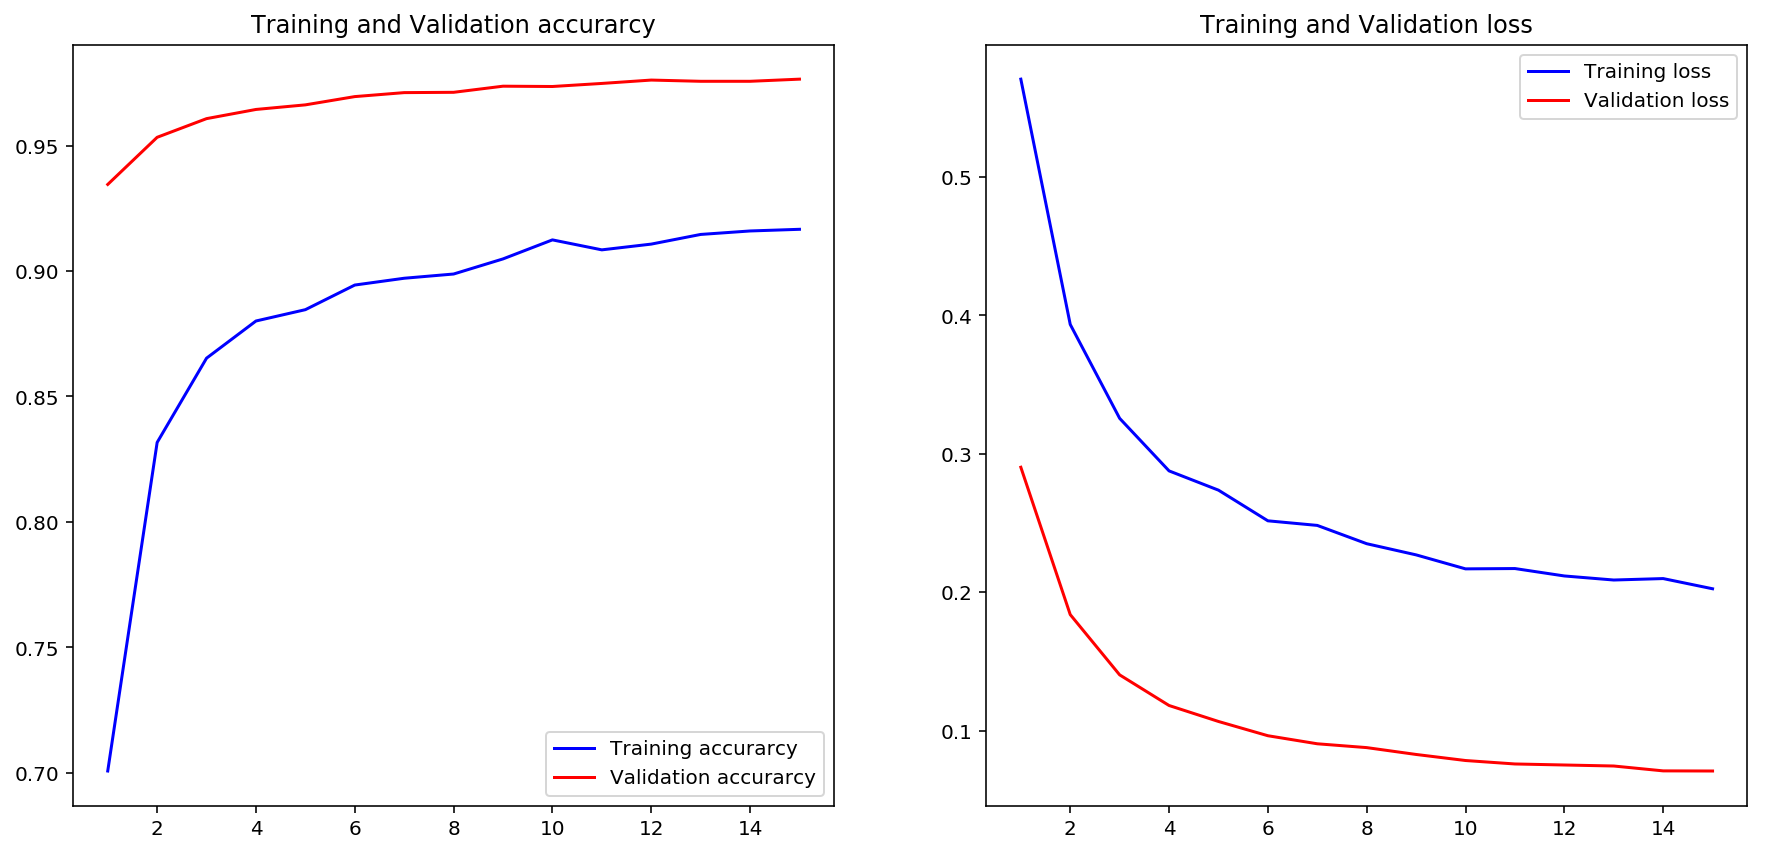

In [15]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.figure(figsize = [15, 7])
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.subplot(1,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# 预测

./test/9810.jpg
0.007628369


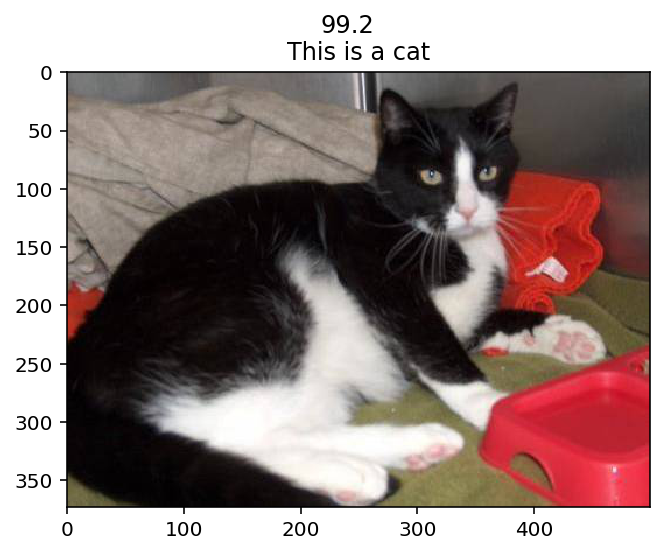

In [16]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
print(img_path)
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.title('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.suptitle('probability: {} percent'.format(round(preds, 3)*100) if preds > 0.5 else round(1-preds, 3)*100);

全部预测，制作csv表

In [17]:
test_imgs = os.listdir(data_dir.format('test'))
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img(data_dir.format('test') + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))

100%|██████████| 12500/12500 [07:47<00:00, 26.72it/s]


In [18]:
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('submission.csv', index = False)

# 参考资料

+ https://zhuanlan.zhihu.com/p/26693647
+ https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
+ https://www.kaggle.com/risingdeveloper/transfer-learning-in-keras-on-dogs-vs-cats